# Using Python to demonstrate simple orbital mechanics
_Authors: Allen Drews (allen.drews@web.de), Arnau Busom Vidal_

This notebook illustrates two different Python functions to integrate the equation governing the motion of a body in the gravitationl field of another:
$$a = \mu / P^2$$
Here the standard gravitational parameter $\mu$ of body 1 (e.g. planet Earth) relates the acceleration $a$ of body 2 (e.g. a satellite) within its gravitational field to the distance between body 2 and the center of body 1 $P$. Note that this only represents the acceleration of body 2 due to the gravity of body 1. Other accelerations are not included. 

This notebook demonstrates:
1. The impact of different initial conditions and different Python functions
2. How to produce stationary and animated plots
3. How to add a simple perturbation to an orbit

In [2]:
# Load relevant modules
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

# Part 1: Calculating orbits

## 1.1 Set intial conditions
In order to demonstrate the impact of the initial values, we give a few different examples.

In [3]:
# Define the state vector by specifying P0 and V0
# Some different P0 - initial positions
P01=[ 6100, 4500, 0]
P02=[-2.3351e4, -2.1746e4, -2.1316e3]

# Some different V0 - initial velocities
V01=[ 2.9268, -0.1393, -0.0792]
V02=[ 2.9268, -1.1393, -0.0792]
V03=[ 0,  8, 3.8]
V04=[-2.7874, 2.6403, 0]

# Some state vectors. Try different combinations of P0 and V0
X01 = np.array([P01, V01])
X02 = np.array([P02, V02])

## 1.2 Do the integration
To update the orbit from the initial values for a range of time steps, we need to solve an initial value problem. There are various Python functions that can be used for this. Here, we compare Scipy's ```odeint``` (_~"ordinary differential equation integration"_) and ```solve_ivp``` (_~"solve initial value problem"_) functions. If you were doing this in Matlab, you could use the ```ode45``` function. 

The arrays solivp1 and solode1 give the positions (P) and velocities (V) for orbit 1 for the given time span, and solivp2 and solode2 give the P and V for orbit 2 for its time span. Note that the order of the arguments is switched between the functions! (solivp: specify [i, :], solode: specify [:, i], i = 0,1,2)

Some sources for the integration: \
https://stackoverflow.com/questions/48428140/imitate-ode45-function-from-matlab-in-python \
https://danielmuellerkomorowska.com/2021/02/16/differential-equations-with-scipy-odeint-or-solve_ivp/

In [4]:
def update_orbit(t, X):
    """
        Function to update the orbit. 
        MU is the standard gravitational parameter:
            MU = G * M, where 
            M = M_Earth = 5.97×10^{24} kg
            G = 6.67×10^{−11} m3⋅kg−1⋅s−2
        
        The change in velocity dV = -mu * P / norm(P)^3.
        
        Using flatten() on the final state vector seems 
        to be necessary for the scipy functions to work.
    """
    MU = 398600    #units: km^3 s^{-2}
    P = X[0:3]     #P-part of the state vector X
    V = X[3:]      #V-part of the state vector X
    
    dP = V
    dV = -MU / (np.linalg.norm(P,2)**3) * P
    return np.array([dP,dV]).flatten()

# Now, use solve_ivp and odeint to update the orbits
# for given time intervals and starting conditions. 
# Note that solve_ivp by default sets its own time-step.
#
# For the second orbit (state vector X02, different initial 
# conditions to X01), we need to make the time longer to 
# get a full orbit.

# SET TIME 
t_start = 0.
t_final = 3600.  # value chosen to get a full orbit with the given initial conditions of X01 and X02
t_step = 50.     # a longer time step will make the animation below quicker, but will reduce the accuracy of the orbit
tspan = np.arange(t_start, t_final, t_step)

# SOLVE_IVP
solivp1 = solve_ivp(update_orbit, [t_start, t_final], X01.flatten())
solivp2 = solve_ivp(update_orbit, [t_start, t_final*10], X02.flatten())

# ODEINT
solode1 = odeint(update_orbit, X01.flatten(), tspan, tfirst=True)
solode2 = odeint(update_orbit, X02.flatten(), tspan*10, tfirst=True)

The orbits are now stored as 6 dimensional state vectors for each time step in the arrays `sol...`. We can take a look at the arrays. Note that the `solve_ivp` function produces a more detailed output than `odeint`. For the solution we obtained with `odeint` we only print the last entry. 

In [5]:
solode1[-1], solivp1

(array([ 6.50037442e+03,  2.93166359e+03, -6.42201809e+01, -2.26224811e+00,
        -3.17712060e+00, -5.19720492e-02]),
   message: 'The solver successfully reached the end of the integration interval.'
      nfev: 218
      njev: 0
       nlu: 0
       sol: None
    status: 0
   success: True
         t: array([0.00000000e+00, 2.81209546e-02, 3.09330501e-01, 3.12142597e+00,
        3.12423806e+01, 3.12451927e+02, 1.04779595e+03, 1.21464775e+03,
        1.38149955e+03, 1.48358547e+03, 1.58567138e+03, 1.63659028e+03,
        1.65736361e+03, 1.67415339e+03, 1.68607372e+03, 1.69276703e+03,
        1.69745810e+03, 1.70214917e+03, 1.70880953e+03, 1.71853149e+03,
        1.73503423e+03, 1.76201632e+03, 1.81100644e+03, 1.89320278e+03,
        2.02093228e+03, 2.24526592e+03, 2.64627689e+03, 3.26527438e+03,
        3.60000000e+03])
  t_events: None
         y: array([[ 6.10000000e+03,  6.10008230e+03,  6.10090508e+03,
          6.10910861e+03,  6.18872726e+03,  6.75020761e+03,
          6.11980

# Part 2: Visualising the orbits
Having the solution in numerical format is good, but we also want to see the orbit. 

## 2.1 Static visualisation
The next two cells show some static visualisations the orbits. We're plotting the solutions for the three components of P for both of the orbits to compare between them. You can also separate them or plot only the V components. 

Notice the different results between the two integration methods! Can you think of where it comes from? (The answer is given below)

<IPython.core.display.Javascript object>


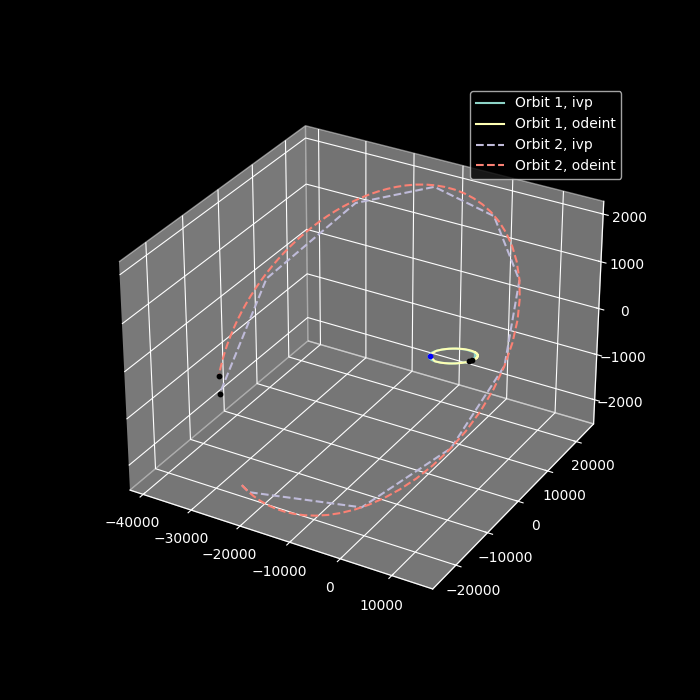

In [6]:
# Set the matplotlib engine
# If the first is uncommented, the plot is movable. If the second is uncommented, the plot will be fixed. 
%matplotlib notebook  
#%matplotlib inline

# Set a dark background... since... space is dark.
plt.style.use('dark_background')

FIG = plt.figure(figsize=(7,7))
AX = FIG.add_subplot(1,1,1, projection='3d')

# Create a blue dot that represents the Earth, add it to the ax 
# (not strictly necessary but nice to illustrate the origin)
AX.scatter([0], [0], [0], color="b", s=10)

# Orbit 1
AX.plot(solivp1.y[0, :], solivp1.y[1, :], solivp1.y[2, :], label='Orbit 1, ivp')
AX.scatter(solivp1.y[0, -1], solivp1.y[1,-1], solivp1.y[2,-1],c='k',s=10)

AX.plot(solode1[:, 0], solode1[:, 1], solode1[:, 2], label='Orbit 1, odeint')
AX.scatter(solode1[-1,0], solode1[-1,1], solode1[-1,2],c='k',s=10)

# Orbit 2
AX.plot(solivp2.y[0, :], solivp2.y[1, :], solivp2.y[2, :], linestyle='--', label='Orbit 2, ivp')#T1, Y1[0,:])
AX.scatter(solivp2.y[0, -1], solivp2.y[1,-1], solivp2.y[2,-1],c='k',s=10)

AX.plot(solode2[:, 0], solode2[:, 1], solode2[:, 2], linestyle='--', label='Orbit 2, odeint')
AX.scatter(solode2[-1,0], solode2[-1,1], solode2[-1,2],c='k',s=10)

# Configuring the plot
AX.legend()

plt.show()

<IPython.core.display.Javascript object>


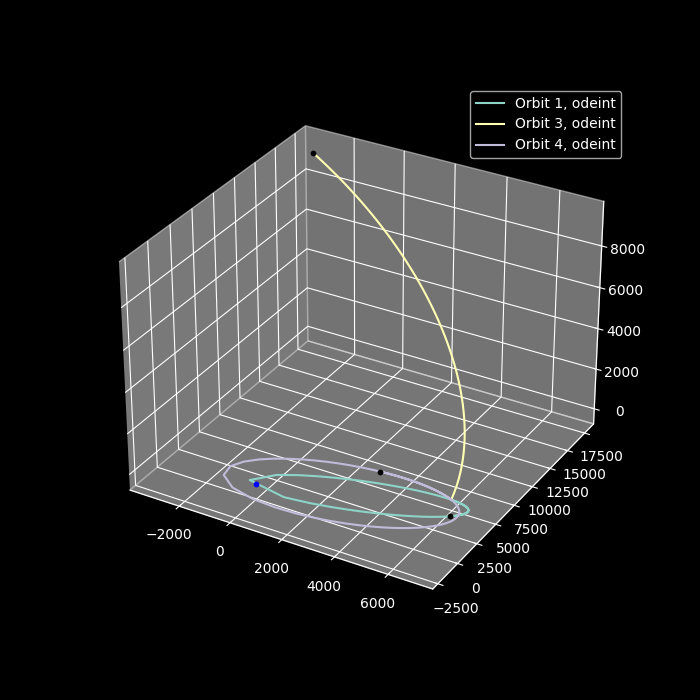

In [7]:
# Make two orbits with the same P0 but different V0 using ODEINT.
# You can see from the plot that they travel different distances
# in the same time. 
X03 = np.array([P01, V03])
X04 = np.array([P01, V04])

solode3 = odeint(update_orbit, X03.flatten(), tspan, tfirst=True)
solode4 = odeint(update_orbit, X04.flatten(), tspan, tfirst=True)

# Plotting
FIG2 = plt.figure(figsize=(7,7))
AX = FIG2.add_subplot(1,1,1, projection='3d')
AX.scatter([0], [0], [0], color="b", s=10)

# Orbit 1 (re-used from above)
AX.plot(solode1[:, 0], solode1[:, 1], solode1[:, 2], label='Orbit 1, odeint')
AX.scatter(solode1[-1,0], solode1[-1,1], solode1[-1,2],c='k',s=10)

# Orbit 3
AX.plot(solode3[:, 0], solode3[:, 1], solode3[:, 2], label='Orbit 3, odeint')
AX.scatter(solode3[-1,0], solode3[-1,1], solode3[-1,2],c='k',s=10)

# Orbit 4
AX.plot(solode4[:, 0], solode4[:, 1], solode4[:, 2], label='Orbit 4, odeint')
AX.scatter(solode4[-1,0], solode4[-1,1], solode4[-1,2],c='k',s=10)

AX.legend()
plt.show()

The difference in the Python methods is due to `solve_ivp`s internal timestep. It is too big to produce a smooth orbit. If you adjust the default settings, it will produce the same detailed plot.

## 2.2 Animated visualisation
It is also possible to produce an animation of the orbit by updating the plot at each time step. This is done by adding a function which updates the plot at each time step. The next step would be to make the same animation but with an added perturbation in the orbit to illustrate e.g. an egine firing.

<IPython.core.display.Javascript object>


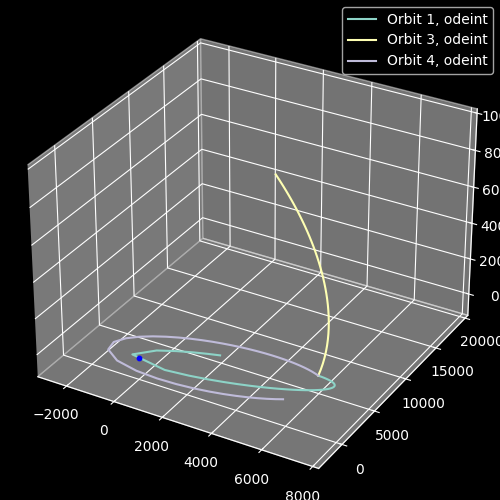

/tmp/ipykernel_6304/2013238421.py:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  AX = Axes3D(FIG3)


In [8]:
# This is all nice but let's animate this same plot
# For some reason it needs to be transposed for the animation to work
solode1 = odeint(update_orbit, X01.flatten(), tspan, tfirst=True).transpose()
solode3 = odeint(update_orbit, X03.flatten(), tspan, tfirst=True).transpose()
solode4 = odeint(update_orbit, X04.flatten(), tspan, tfirst=True).transpose()

# Initialise the figure
FIG3 = plt.figure(figsize=(5,5))
AX = Axes3D(FIG3)

# Initialise the plots (they cannot be empty in 3D)
orbitPlots = [AX.plot(solode1[0, 0:1], solode1[1, 0:1], solode1[2, 0:1], label='Orbit 1, odeint')[0], AX.plot(solode3[0, 0:1], solode3[1, 0:1], solode3[2, 0:1], label='Orbit 3, odeint')[0], AX.plot(solode4[0, 0:1], solode4[1, 0:1], solode4[2, 0:1], label='Orbit 4, odeint')[0]]
orbitData = [solode1,solode3,solode4]

# Make a function that will be called to update every frame
def animate(i, data, plots):
    if i==0:
        return plots
    else:
        for plot, dat in zip(plots, data):
            plot.set_data(dat[0:2,:i])
            plot.set_3d_properties(dat[2,:i])
        return plots

# Setting the axes properties and adding Earth
AX.scatter([0], [0], [0], color="b", s=10)
#AX.axis("off")
AX.set_xlim3d([-3000, 8000])
AX.set_ylim3d([-3000, 20000])
AX.set_zlim3d([-1000, 10000])
AX.set_title('3D Trajectories')
AX.legend()

#Call the magic function that makes the animation
animation = FuncAnimation(FIG3, animate, fargs=(orbitData, orbitPlots), 
                          frames=range(len(solode3[0,:])), interval=10, 
                          repeat=True, blit=False)
plt.show()

# Part 3: Adding a perturbation to an orbit

In [9]:
def orbit_with_perturbation(Tinit, Tfin, Percent_time, Tstep, Init_state_vector, Pert):
    """
        Function to add a perturbation ("pert") to an orbit with the 
        initial state vector ("init_state_vector") after a certain
        percentage ("percent_time", e.g. 0.1 for 10%) of the total
        time ("tfin" - "tinit") has passed. 
        
         - This function calls the function "update_orbit".
         - tstep is the time step of the integration. 
         - The perturbation "pert" is a list of six values (3x position, 
           3x velocity values).
        
    """
    tspan = np.arange(Tinit, Percent_time*Tfin, Tstep)
    sol1 = odeint(update_orbit, Init_state_vector.flatten(), tspan, tfirst=True)
    
    perturbed_state = sol1[-1] + Pert
    
    tspan = np.arange(Percent_time*Tfin, Tfin, Tstep)
    sol2 = odeint(update_orbit, perturbed_state.flatten(), tspan, tfirst=True)  
    
    return np.append(sol1,sol2, axis=0)

In [10]:
# Two example perturbations for the same initial state X01:
t_start = 0
t_final = 10000.
t_pert = 0.25   # after 25% of the total time has passed, the orbit is perturbed by a change in velocity
t_step = 10.
X05 = np.array([P01, V04])
init_sv = X05.flatten()

perturbation1 = [0, 0, 0, 0.1, 1., 0.]
pert_sol1 = orbit_with_perturbation(t_start, 
                                   t_final, 
                                   t_pert,
                                   t_step, 
                                   init_sv, 
                                   perturbation1)

perturbation2 = [0, 0, 0, 0, 1., 5.]
pert_sol2 = orbit_with_perturbation(t_start, 
                                   t_final, 
                                   t_pert,
                                   t_step, 
                                   init_sv, 
                                   perturbation2)

<IPython.core.display.Javascript object>


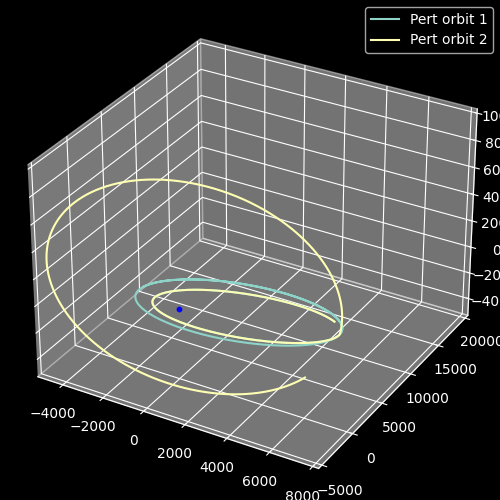

/tmp/ipykernel_6304/2319008876.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  AX = Axes3D(FIG4)


In [13]:
# Initialise the figure
FIG4 = plt.figure(figsize=(5,5))
AX = Axes3D(FIG4)

# Initialise the plots (they can no be empty in 3D)
orbitPlots = [AX.plot(pert_sol1[0, 0:1], pert_sol1[1, 0:1], pert_sol1[2, 0:1], label='Pert orbit 1')[0],
             AX.plot(pert_sol2[0, 0:1], pert_sol2[1, 0:1], pert_sol2[2, 0:1], label='Pert orbit 2')[0]]
orbitData = [pert_sol1.transpose(),
            pert_sol2.transpose()]

# Setting the axes properties and adding Earth
AX.scatter([0], [0], [0], color="b", s=10)
AX.set_xlim3d([-5000, 8000])
AX.set_ylim3d([-5000, 20000])
AX.set_zlim3d([-5000, 10000])
AX.legend()

# Call the magic function that makes the animation
animation = FuncAnimation(FIG4, animate, fargs=(orbitData, orbitPlots), 
                          frames=range(len(pert_sol1[:,0])), 
                          interval=10, 
                          repeat=True, 
                          blit=False)
plt.show()